# Transformer와 비교해 변경이 필요한 부분 서술

- Transformer 구조
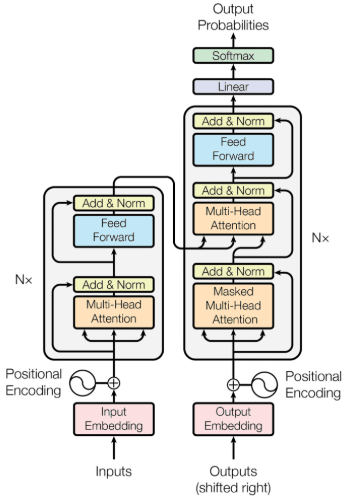
- GPT 구조
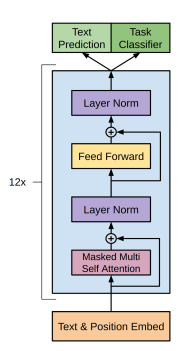


- 위 그림과 같이 GPT 모델은 Transformer 모델과 달리
    - Encoder 구조가 없음
    - Decoder에 Cross self attention 구조가 없음
    - Decoder 레이어가 masked multi-headed self attention 구조와 feed forward 구조로 구성되어 있음
    - Linear 레이어 대신 Transposed embeding 레이어가 최종 출력에 연산되며, 이후 Softmax 레이어에 연결됨
    - GPT-1의 경우 12겹의 Decoder 레이어로 구성되어 있음

## 모델의 입력 형태에 맞는 전처리
- 아래 작성된 순으로 텍스트를 전처리하였으며, 함수에서 해당사항 확인 가능
    - 텍스트 정규화
    - 텍스트 토큰화
    - 텍스트 길이 정규화
    - 텍스트 입력블럭화
    - 텍스트 패딩 수행
    - 교사 강요화 수행

## 모델 입력 블럭 수정

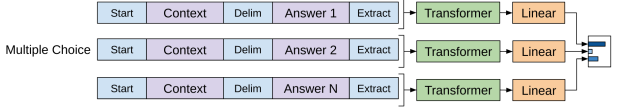

- 위 사진 및 Improving Language Understanding by Generative Pre-Training(Alec et al.,2018) 내용 참조
- All transformations include adding randomly initialized start and end tokens <4p, 3.3 Task-specific input transformations 내용 발최>
- Question Answering and Commonsense Reasoning의 경우 사이에 delimiter token 추가 <4p, 3.3 Task-specific input transformations 내용 발최>

- 본 과제의 경우 하나의 context와 다수의 답변이 들어가는 것이 아니기 때문에 [Start][Question1][Delim][Ansewr1][End] 구조 일 것

## GPT 모델 결과 첨부
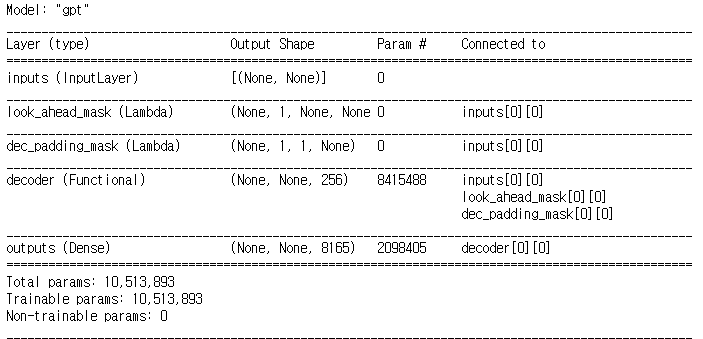
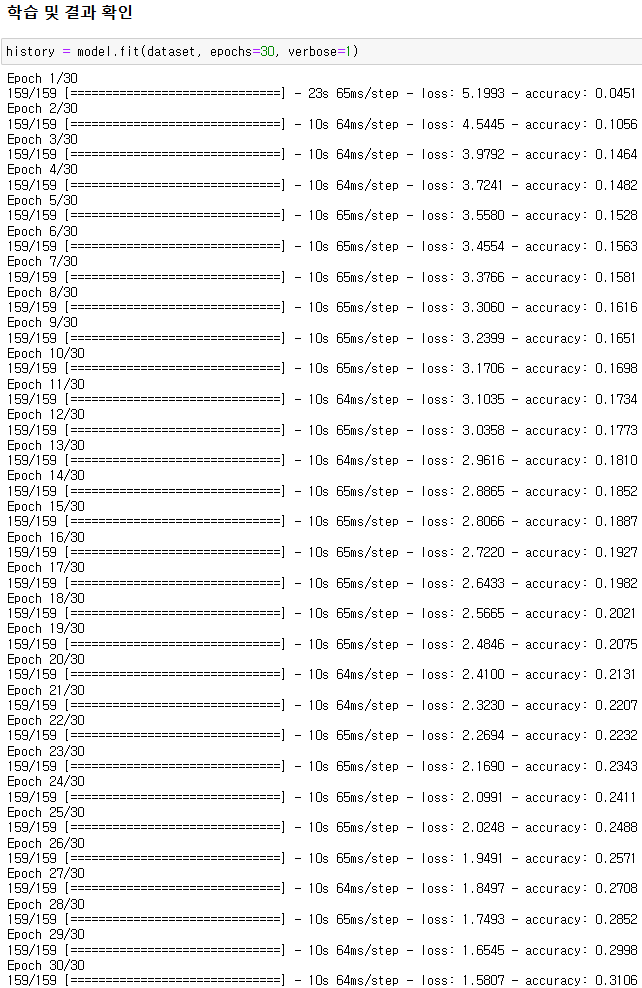

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from konlpy.tag import Okt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 데이터 전처리 함수

In [4]:
# 데이터 import
def import_data(data_name):
    imported_data = 0
    data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'+data_name
    imported_data = pd.read_csv(data_path)
    return imported_data


# 불용어 제거를 위한 함수
def cleaning_sentence(sentence):
        sentence = sentence.lower()
        sentence = BeautifulSoup(sentence, "lxml").text
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'\([^)]*\)', '', sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub("[^가-힣a-zA-Z0-9\.\?\!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence


# 불용어 제거
def preprocess_sentence(data_list):
    retrun_list = []
    
    if isinstance(data_list, list):
        for sentence_frame in data_list:
            single_list = []
            for sentence in sentence_frame:
                cleaned_sentence = cleaning_sentence(sentence)
                single_list.append(cleaned_sentence)
            retrun_list.append(single_list)
    else:
        cleaned_sentence = cleaning_sentence(data_list)
        retrun_list = cleaned_sentence
        
    return retrun_list


# 토크나이저 기반 단어장 생성
def make_voca(data_list):
    questions = data_list[0]
    answers = data_list[1]
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
    START_TOKEN, DELIM_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size + 2]
    st_token = [START_TOKEN, DELIM_TOKEN, END_TOKEN]
    vocab_size = tokenizer.vocab_size + 3
    return tokenizer, st_token, vocab_size


# 생성된 단어장 기반으로 문장 토큰화
def tokenizer_encoding(data_list, tokenizer, st_token):
    encoding_data = []
    for sentence_list in data_list:
        encoding_sentence = []
        for sentence in sentence_list:
            a_sentence = tokenizer.encode(sentence)
            encoding_sentence.append(a_sentence)
        encoding_data.append(encoding_sentence)
        
    encoded_data = {'question' : encoding_data[0], 'answer' : encoding_data[1]}
    
    return encoded_data


# 문장 적정 길이 계산을 위한 함수
def visual_len(data_dic, rato):
    question_len = [len(s) for s in data_dic['question']]
    answer_len = [len(s) for s in data_dic['answer']]
    print('question len. max :', np.max(question_len), ', min :', np.min(question_len), ', aver :', np.mean(question_len), ', var :', np.var(question_len))
    print('answer len. max :', np.max(answer_len), ', min :', np.min(answer_len), ', aver :', np.mean(answer_len), ', var :', np.var(answer_len))
    
    question_len = sorted(question_len)
    q_rato_index = int(len(question_len)*rato)
    answer_len = sorted(answer_len)
    a_rato_index = int(len(answer_len)*rato)
    print('your question rate set as : ', question_len[q_rato_index])
    print('your answer rate set as : ', answer_len[a_rato_index])
    return


# 문장 길이 정규화
def cut_len(data_dic, max_len):
    return_dic = {}
    cutten_dic = {}
    
    for name in ['question', 'answer']:
        single_cutten_list = []
        for single_list in data_dic[name]:
            if len(single_list) > max_len :
                return_list = 'del'
            else :
                return_list = single_list
            single_cutten_list.append(return_list)
        cutten_dic[name] = single_cutten_list
        
    cutten_df = pd.DataFrame.from_dict(cutten_dic)
    cutten_df.replace('del', np.nan, inplace=True)
    cutten_df.dropna(axis=0, inplace=True)
    return_dic = cutten_df.to_dict('list')
    max_len = 2*max_len + 3
    
    return return_dic, max_len

# Start, Delim, End 토큰 추가
def add_st_token(data_dic, st_token):
    question = data_dic['question']
    ansewr = data_dic['answer']
    return_list = []
    
    for single_question, single_ansewr in zip(question, ansewr):
        out_q_seq = st_token[0] + single_question + st_token[1]
        out_a_seq = single_ansewr + st_token[2]
        out_seq = out_q_seq + out_a_seq
        return_list.append(out_seq)
    
    return return_list

# 문장 길이 정규화를 위한 패딩
def take_padding(data_list, max_len):
    return_list = tf.keras.preprocessing.sequence.pad_sequences(data_list, maxlen=max_len, padding='post')
    return return_list
    
# 교사 강요를 위한 데이터셋을 제작하는 함수
def teacher_extortion(data_list, BATCH_SIZE, BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((
        {'inputs': data_list[:, :-1]},
        {'outputs': data_list[:, 1:]},))
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

## 모델 구축을 위한 함수

In [27]:
# 어텐션 점곱 계산 식
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output


# 패딩 마스크 생성을 위한 함수 (패딩된 부분을 1로 표시한)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


# 룩 어헤드 마스크 생성을 위한 함수 (디코더 셀프 마스크 어텐션시)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


# loss 및 metric 함수
def loss_function(y_true, y_pred, max_len = max_len):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred, max_len = max_len):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

### 포지셔널 인코딩 구현

In [28]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 멀티 헤드 어텐션 구현

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value =  self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        return outputs

### 커스텀 learning rate

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 모델 구축 함수

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)
    
    return tf.keras.Model(inputs=[inputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [33]:
def GPT(vocab_size,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name="gpt"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)
    
    padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, look_ahead_mask, padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [85]:
def decoder_inference(sentence, tokenizer, st_token, max_len, top_k):
    return_list = []
    max_len = int((max_len-3)/2)
    
    START_TOKEN = st_token[0]
    DELIM_TOKEN = st_token[1]
    END_TOKEN = st_token[2]
    
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + DELIM_TOKEN, axis=0)
    in_put = sentence
    
    for i in range(max_len):
        predictions = model(inputs=[in_put], training=False)
        predictions = predictions[:, -1:, :]
        
        if top_k > 0:
            predictions = tf.squeeze(predictions, axis=1)
            top_k_values, top_k_indices = tf.nn.top_k(predictions, k=top_k)
            top_k_probabilities = tf.nn.softmax(top_k_values)
            sampled_index = tf.random.categorical(tf.math.log(top_k_probabilities), num_samples=1)
            predicted_id = tf.gather(top_k_indices[0], sampled_index[0][0])
            predicted_id = tf.expand_dims(predicted_id, axis=0)
            predicted_id = tf.expand_dims(predicted_id, axis=0)
        else:
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        in_put = predicted_id
        return_list.append(predicted_id[0][0])
        
        if tf.equal(predicted_id[0], END_TOKEN):
            break
                
    return_tensor = tf.convert_to_tensor(return_list)
    
    return return_tensor

def sentence_generation(sentence,  tokenizer, st_token, max_len, temperature=1):
    prediction = decoder_inference(sentence,  tokenizer, st_token, max_len, temperature)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

# 모델 시현

### 데이터 import - 전처리

In [19]:
data = import_data('ChatbotData .csv')
data_list = [data['Q'], data['A']]

In [20]:
preprocessed_data_list = preprocess_sentence(data_list)

tokenizer, st_token, vocab_size = make_voca(preprocessed_data_list)

encoded_data = tokenizer_encoding(preprocessed_data_list, tokenizer, st_token)

In [21]:
visual_len(encoded_data, 0.9)

question len. max : 21 , min : 1 , aver : 5.484986889960247 , var : 6.268889890295859
answer len. max : 29 , min : 1 , aver : 5.818404804195213 , var : 6.775701185368106
your question rate set as :  9
your answer rate set as :  9


In [22]:
cutten_data, max_len = cut_len(encoded_data, 9)

adden_data = add_st_token(cutten_data, st_token)

padding_data = take_padding(adden_data, max_len)

In [23]:
dataset = teacher_extortion(padding_data, 64, 20000)

In [24]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 20)}, {outputs: (None, 20)}), types: ({inputs: tf.int32}, {outputs: tf.int32})>

In [25]:
[(my_features, my_batch)] = dataset.take(1)

my_features = my_features['inputs']
my_batch = my_batch['outputs']

In [26]:
print(my_features[0])
print(my_batch[0])

tf.Tensor(
[8162   53 4857 1704  190 1939 8163 1116 1851    3    1 8164    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int32)
tf.Tensor(
[  53 4857 1704  190 1939 8163 1116 1851    3    1 8164    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int32)


### 모델 구축

In [35]:
tf.keras.backend.clear_session()

VOCAB_SIZE = vocab_size
NUM_LAYERS = 12
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

In [36]:
model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8415488     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]          

In [37]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 학습 및 결과 확인

In [38]:
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
159/159 [==============================] - 23s 65ms/step - loss: 5.1993 - accuracy: 0.0451
Epoch 2/30
159/159 [==============================] - 10s 64ms/step - loss: 4.5445 - accuracy: 0.1056
Epoch 3/30
159/159 [==============================] - 10s 64ms/step - loss: 3.9792 - accuracy: 0.1464
Epoch 4/30
159/159 [==============================] - 10s 64ms/step - loss: 3.7241 - accuracy: 0.1482
Epoch 5/30
159/159 [==============================] - 10s 65ms/step - loss: 3.5580 - accuracy: 0.1528
Epoch 6/30
159/159 [==============================] - 10s 65ms/step - loss: 3.4554 - accuracy: 0.1563
Epoch 7/30
159/159 [==============================] - 10s 65ms/step - loss: 3.3766 - accuracy: 0.1581
Epoch 8/30
159/159 [==============================] - 10s 65ms/step - loss: 3.3060 - accuracy: 0.1616
Epoch 9/30
159/159 [==============================] - 10s 65ms/step - loss: 3.2399 - accuracy: 0.1651
Epoch 10/30
159/159 [==============================] - 10s 65ms/step - loss: 3.170

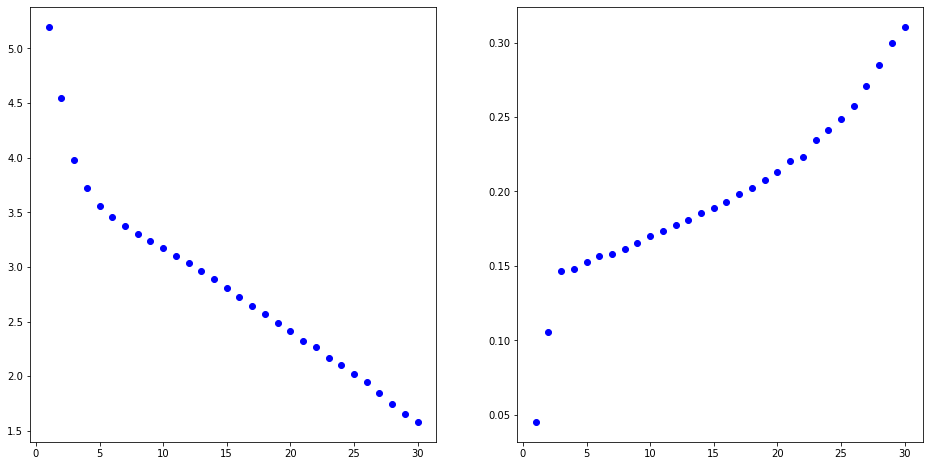

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
axes[0].plot(epochs, loss, "bo", label="Training loss",)

acc = history.history["accuracy"]
epochs = range(1, len(acc) + 1)
axes[1].plot(epochs, acc, "bo", label="Training accuracy",)

### 모델 구동

In [86]:
sentence_generation("반가워",  tokenizer, st_token, max_len, 1)

입력 : 반가워
출력 : 제가 설레여화장실 가고 싶어인링 


'제가 설레여화장실 가고 싶어인링 '

In [156]:
sentence_generation("안녕",  tokenizer, st_token, max_len, 3)

입력 : 안녕
출력 : 좋아하는 했어


'좋아하는 했어'

# 디버그 사항

- 수정전1
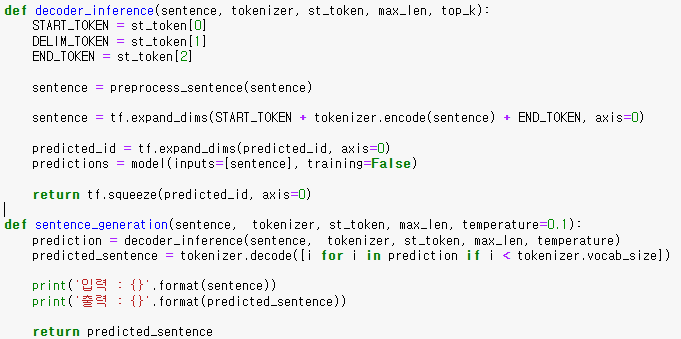
- 수정전2
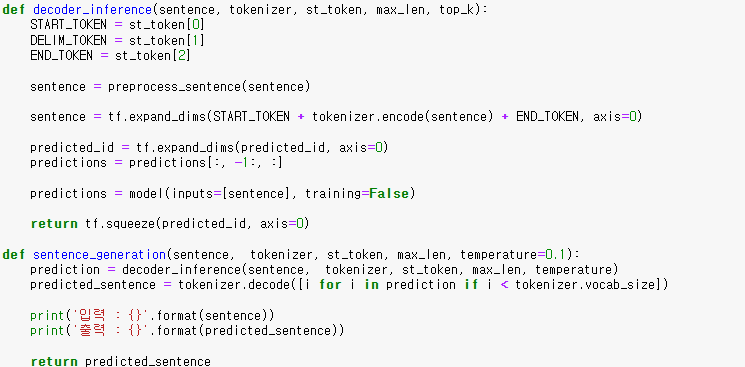
- 수정전3
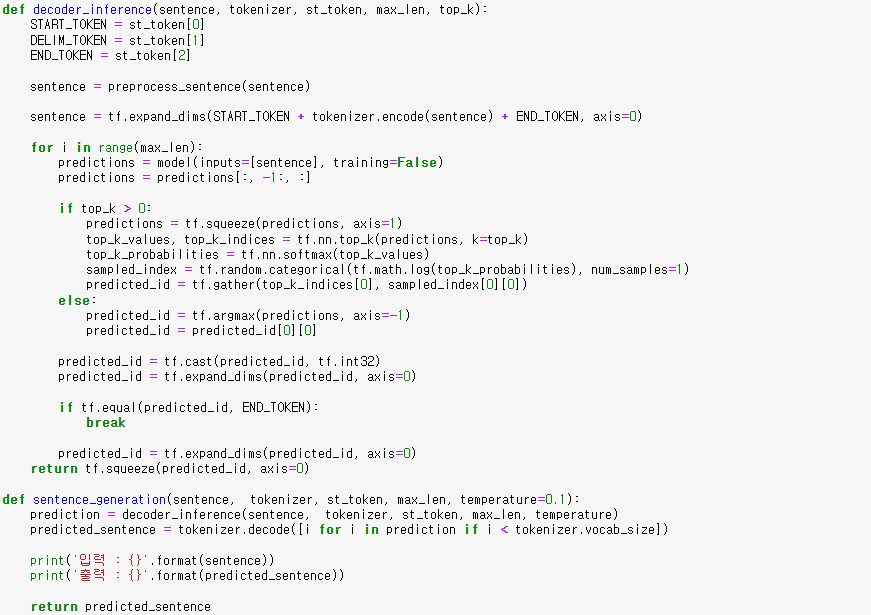

- 위와 같이 기존의 코드를 약간 손보았을 때는 몇가지 문제가 발생하였음
    - 문맥이 없이 동일한 순서 느낌의 단어만 나옴
    - 단어가 한개만 나옴
    - 차원 문제로 구동하지 않음
- 아래와 같이 수정하였을 때 문제가 해결되고 정상적으로 구동함
    - 수정후
    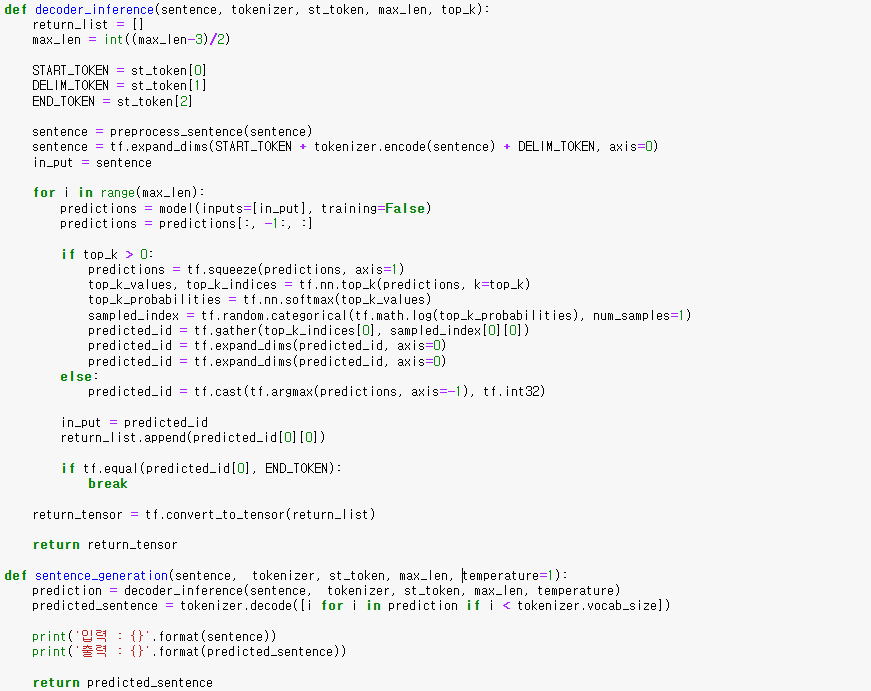
- 추가적으로 위의 문장 입력 블럭을 생각해 봤을 때
    [Start_token][sentence][End_token]의 입력이 아니라
    [Start_token][sentence][Delim_token]의 입력이 여야하며, 실제로 본 입력의 답변이 더 현실적임
    
- [Start_token][sentence][End_token] 입력시 출력
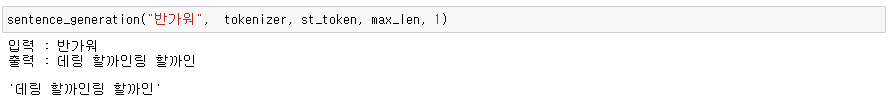

- [Start_token][sentence][Delim_token] 입력시 출력
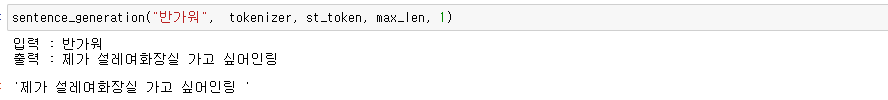

# 회고
- 실험적 측면
    - 다른 loss 및 metric을 사용하면 좋을 것같음
    - 이후 모델도 구현해보면 좋을 것같음
    - 다른 데이터에서 적용해보면 좋을 것같음